In [1]:
    import sys
    import json
    # sys.path.append(r"c:\Users\beunk\OneDrive - Stichting Deltares\Documents\Python Scripts\my_own_packages")
    # from importlib import reload
    # from gww_client import client as cli
    # cli = reload(cli)
    import client as cli 
    geom_path = r'c:\Users\beunk\OneDrive - Stichting Deltares\Documents\Python Scripts\11208020-038\data\basins.geojson'       


In [2]:
with open(geom_path,'r') as f:
    data = json.loads(f.read())
data = data['features'][1]['geometry']
geom = json.dumps(data)
gww_reservoirs = cli.get_reservoirs_by_geom(geom).json()

gpd2 = cli.to_geopandas(gww_reservoirs)
df = gpd2.loc[:,['source_id', 'id']].set_index('source_id')
d = df.to_dict()['id']    

In [3]:
gpd2['area'] = gpd2['geometry'].to_crs('WGS84').area
gpd2 = gpd2.sort_values('area', ascending=False).iloc[:10,:]
print(gpd2)
print(int(gpd2.loc[107,'grand_id']))

                name name_en  grand_id source_name  source_id     id  \
107             None    None    3014.0        None       1545  89619   
106  Barrage de Ziga    None    6919.0        None    6168133  88175   
25              None    None    2981.0        None      15776  86415   
24              None    None       NaN        None    1399145  85767   
105             None    None    3001.0        None     179464  84765   
23              None    None    2987.0        None     179336  82016   
22              None    None    2976.0        None     179149  81878   
21              None    None    2995.0        None     179406  79870   
104             None    None    3002.0        None     179503  79427   
20              None    None    2973.0        None     179128  78386   

                                              geometry      area  
107  MULTIPOLYGON (((-0.85526 11.68462, -0.85526 11...  0.019437  
106  MULTIPOLYGON (((-1.15737 12.54025, -1.15723 12...  0.006254  
25   M

C:\Users\beunk\AppData\Local\Temp\ipykernel_19188\3389824221.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd2['area'] = gpd2['geometry'].to_crs('WGS84').area


In [4]:
from matplotlib import pyplot
import hydroengine as he
import pandas as pd

In [5]:
def a(i):
    ts_he = he.get_lake_time_series(int(gpd2.loc[i, 'source_id']), variable='water_area')
    ts_he_pd = pd.DataFrame(ts_he)
    idx = pd.to_datetime(ts_he_pd['time']*1000000)
    v = ts_he_pd['water_area'].values
    return pd.DataFrame(v, index=pd.DatetimeIndex(idx).date)

def b(i):
    ts_gww = cli.get_reservoir_ts(int(gpd2.loc[i,'id'])).json()
    ts_gww = cli.to_timeseries(ts_gww)
    return ts_gww

def m(i):
    ts_gww_m = cli.get_reservoir_ts_fitted(int(gpd2.loc[i,'id'])).json()
    ts_gww_m = cli.to_timeseries(ts_gww_m)
    return ts_gww_m


In [10]:
test = m(105)
print(test)

                    area
2010-01-01  9.346252e+06
2010-02-01  9.402592e+06
2010-03-01  9.470055e+06
2010-04-01  9.510724e+06
2010-05-01  9.548320e+06
...                  ...
2021-08-01  9.157969e+06
2021-09-01  9.787176e+06
2021-10-01  9.337026e+06
2021-11-01  8.968440e+06
2021-12-01  8.974819e+06

[144 rows x 1 columns]


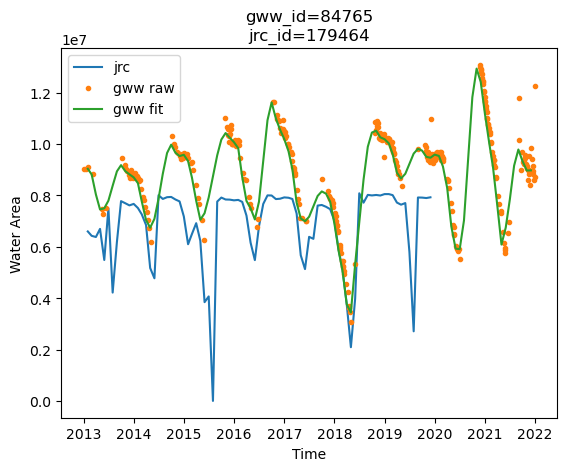

In [19]:
for i in [105]: #in gpd2.index:
    try:
        ts_he = a(i)
        ts_gww = b(i)
        ts_gww_m = m(i)

        ts_he.index = pd.to_datetime(ts_he.index)
        ts_gww.index = pd.to_datetime(ts_gww.index)
        ts_gww_m.index = pd.to_datetime(ts_gww_m.index)

        ts_he = ts_he.loc[ts_he.index > '2013-01-01']
        ts_gww = ts_gww.loc[ts_gww.index > '2013-01-01']
        ts_gww_m = ts_gww_m.loc[ts_gww_m.index > '2013-01-01']

        outpath = r'c:\Users\beunk\OneDrive - Stichting Deltares\Documents\Python Scripts\11208020-038\data\comparison_output\timeseries'

        fig, ax = pyplot.subplots()
        ax.plot(ts_he, label='jrc')
        ax.plot(ts_gww, '.', label = 'gww raw')
        ax.plot(ts_gww_m, label = 'gww fit')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Water Area')
        ax.set_title(f"gww_id={gpd2.loc[i,'id']}" "\n" f"jrc_id={int(gpd2.loc[i,'source_id'])}")
        fig.savefig(outpath+f"\gww_id_{gpd2.loc[i,'id']}")
    except:
        print('failed')
        continue




<AxesSubplot: >

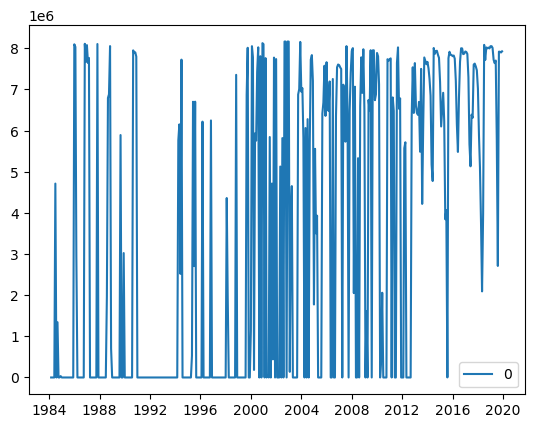

In [13]:
# print(ts_he)

# # ts_he = pd.to_datetime(ts_he.index)

# # print(ts_he)

ts_he.plot()

In [ ]:
gpd2.to_file(f'{outpath}\gpd2.shp')

C:\Users\beunk\AppData\Local\Temp\ipykernel_4872\4062549895.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd2.to_file(f'{outpath}\gpd2.shp')
